In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images412.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images77.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images (117).jpeg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images210.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images825.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images839.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images68.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images69.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images (244).jpeg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images396.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images85.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images239.jpg
/kaggle/input/poachingdataset/Binary-poachingDataset/test/no/images (276).jpeg
/kaggle/input/poa

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy 
import torchvision.transforms as transforms
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm.auto import tqdm

In [3]:
train_transforms_ = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    #transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
test_transforms_=transforms.Compose([
    transforms.Resize((224, 224)),  
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
from PIL import Image

def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        img = img.convert("RGBA")  
        
        return img.convert("RGB")  

In [7]:
train_dataset=ImageFolder(root='/kaggle/input/poachingdataset/Binary-poachingDataset/train',transform=train_transforms_,target_transform=None,loader=pil_loader)
test_dataset=ImageFolder(root='/kaggle/input/poachingdataset/Binary-poachingDataset/test',transform=test_transforms_,target_transform=None,loader=pil_loader)
print(f"Length of train dataset:{len(train_dataset)}")
print(f"Length of test dataset:{len(test_dataset)}")

Length of train dataset:4258
Length of test dataset:1000


In [8]:
class_list=train_dataset.classes
print(class_list)

['no', 'yes']


In [9]:
class_dict=train_dataset.class_to_idx
print(class_dict)

{'no': 0, 'yes': 1}


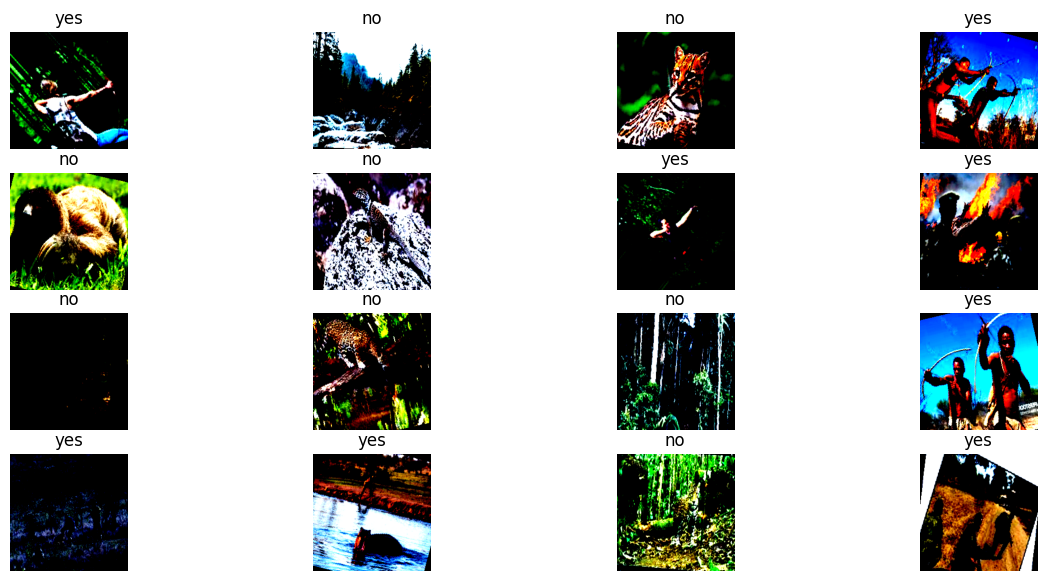

In [10]:
plt.figure(figsize=(15,7))
nrows,ncols,idx=4,4,1

for idx in range(1,17):
    plt.subplot(nrows,ncols,idx)
    random_idx=np.random.randint(0,len(train_dataset))
    img,label=train_dataset[random_idx]
    plt.imshow(img.permute(1,2,0).numpy())
    plt.title(class_list[label])
    plt.axis('off')
    

In [11]:
torch.cuda.manual_seed(42)
BATCH_SIZE=32

train_dataloader=DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=True)
print(f"No of batches for train_dataloader:{len(train_dataloader)}")
print(f"No of batches for test dataloader:{len(test_dataloader)}")

No of batches for train_dataloader:134
No of batches for test dataloader:32


In [12]:
img_batch,label_batch=next(iter(train_dataloader))
print(img_batch.shape)
print(label_batch.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [56]:
resnet_big_weights=models.ResNet101_Weights.DEFAULT
myresnet=models.resnet101(weights=resnet_big_weights)
myresnet.fc,myresnet.fc.in_features

(Linear(in_features=2048, out_features=1000, bias=True), 2048)

In [55]:
resnet_weights=models.ResNet50_Weights.DEFAULT
myresnet=models.resnet50(weights=resnet_weights)
myresnet.fc,myresnet.fc.in_features

(Linear(in_features=2048, out_features=1000, bias=True), 2048)

In [57]:
class GarudaDrishti(nn.Module):
    def __init__(self,num_classes,resnet_weights):
        super().__init__()
        self.model=models.resnet101(weights=resnet_weights)
        self.model.fc=nn.Linear(in_features=self.model.fc.in_features,out_features=1)
        
    def forward(self,X:torch.Tensor):
        return self.model(X)
    
    

In [58]:
device="cuda" if torch.cuda.is_available else "cpu"
print(f"Using:{device}")

Using:cuda


In [59]:
model=GarudaDrishti(num_classes=len(class_list),resnet_weights=resnet_big_weights).to(device)
print(f"Model is running on device:{next(model.parameters()).device}")

Model is running on device:cuda:0


In [60]:
from torchinfo import summary
summary(model=model,input_size=[1,3,256,256])


Layer (type:depth-idx)                        Output Shape              Param #
GarudaDrishti                                 [1, 1]                    --
├─ResNet: 1-1                                 [1, 1]                    --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 64, 64]          70,400
│    └─Sequential: 2-6                        [1, 512, 32, 32]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 32, 32]          379,392

In [61]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.0001)


In [62]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [27]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs_list=[]
train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]
EPOCHS=40

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_loss,train_acc=0,0
    for X,y in train_dataloader:
        X,y=X.to(device),y.to(device).float().unsqueeze(1)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        train_loss += loss.item()
        y_pred_labels=torch.round(torch.sigmoid(y_pred))
        train_acc += accuracy_fn(y_true=y,y_pred=y_pred_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /=len(train_dataloader)
    train_acc /=len(train_dataloader)
    epochs_list.append(epoch+1)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test,y_test=X_test.to(device),y_test.to(device).float().unsqueeze(1)
            y_test_pred=model(X_test)
            loss=loss_fn(y_test_pred,y_test)
            test_loss +=loss.item()
            y_test_labels=torch.round(torch.sigmoid(y_test_pred))
            test_acc += accuracy_fn(y_true=y_test,y_pred=y_test_labels)
        test_loss /=len(test_dataloader)
        test_acc /=len(test_dataloader)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
    print(f"Epoch:{epoch+1} | Train_loss:{train_loss} | Train_Acc:{train_acc} |Test_loss:{test_loss} |Test_Acc:{test_acc}")
            
    
    

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch:1 | Train_loss:0.16986758930525228 | Train_Acc:95.35914179104478 |Test_loss:0.026458424908923917 |Test_Acc:99.12109375
Epoch:2 | Train_loss:0.03500820124181293 | Train_Acc:99.09048507462687 |Test_loss:0.03073504311760189 |Test_Acc:99.21875


KeyboardInterrupt: 

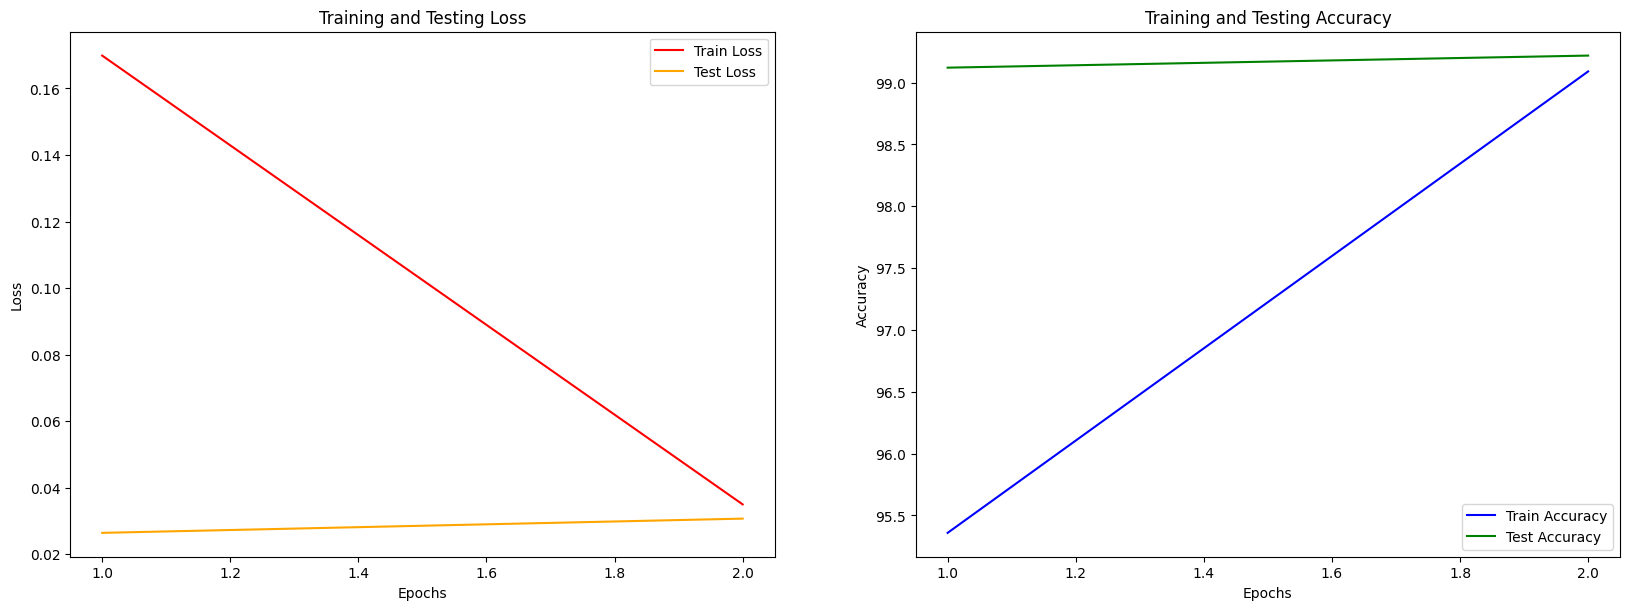

In [28]:
plt.figure(figsize=(20, 15))

nrows, ncols = 2, 2

plt.subplot(nrows, ncols, 1)
plt.plot(epochs_list, train_loss_list, color='red', label='Train Loss')
plt.plot(epochs_list, test_loss_list, color='orange', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(nrows, ncols, 2)
plt.plot(epochs_list, train_acc_list, color='blue', label='Train Accuracy')
plt.plot(epochs_list, test_acc_list, color='green', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.savefig('training_testing_plot.png', dpi=300, bbox_inches='tight')
plt.legend()

In [63]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs_list=[]
train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]
EPOCHS=40

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_loss,train_acc=0,0
    for X,y in train_dataloader:
        X,y=X.to(device),y.to(device).float().unsqueeze(1)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        train_loss += loss.item()
        y_pred_labels=torch.round(torch.sigmoid(y_pred))
        train_acc += accuracy_fn(y_true=y,y_pred=y_pred_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /=len(train_dataloader)
    train_acc /=len(train_dataloader)
    epochs_list.append(epoch+1)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test,y_test=X_test.to(device),y_test.to(device).float().unsqueeze(1)
            y_test_pred=model(X_test)
            loss=loss_fn(y_test_pred,y_test)
            test_loss +=loss.item()
            y_test_labels=torch.round(torch.sigmoid(y_test_pred))
            test_acc += accuracy_fn(y_true=y_test,y_pred=y_test_labels)
        test_loss /=len(test_dataloader)
        test_acc /=len(test_dataloader)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
    print(f"Epoch:{epoch+1} | Train_loss:{train_loss} | Train_Acc:{train_acc} |Test_loss:{test_loss} |Test_Acc:{test_acc}")
            
    
    

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch:1 | Train_loss:0.13820948253677628 | Train_Acc:96.85167910447761 |Test_loss:0.02398175123744295 |Test_Acc:99.51171875
Epoch:2 | Train_loss:0.03224528836583329 | Train_Acc:99.09048507462687 |Test_loss:0.03603911027494178 |Test_Acc:99.21875
Epoch:3 | Train_loss:0.02574047438171345 | Train_Acc:99.13712686567165 |Test_loss:0.03915570895878773 |Test_Acc:99.12109375
Epoch:4 | Train_loss:0.013128603313382326 | Train_Acc:99.55690298507463 |Test_loss:0.024470893666602933 |Test_Acc:99.21875
Epoch:5 | Train_loss:0.013701781797102902 | Train_Acc:99.67350746268657 |Test_loss:0.025311332794444752 |Test_Acc:99.4140625
Epoch:6 | Train_loss:0.03219427378850801 | Train_Acc:99.25373134328358 |Test_loss:0.02158529218104377 |Test_Acc:99.31640625
Epoch:7 | Train_loss:0.023780779283643187 | Train_Acc:99.32369402985074 |Test_loss:0.026129028777177155 |Test_Acc:98.828125
Epoch:8 | Train_loss:0.005172192965027765 | Train_Acc:99.95335820895522 |Test_loss:0.028700176851089054 |Test_Acc:99.4140625
Epoch:9 | 

KeyboardInterrupt: 

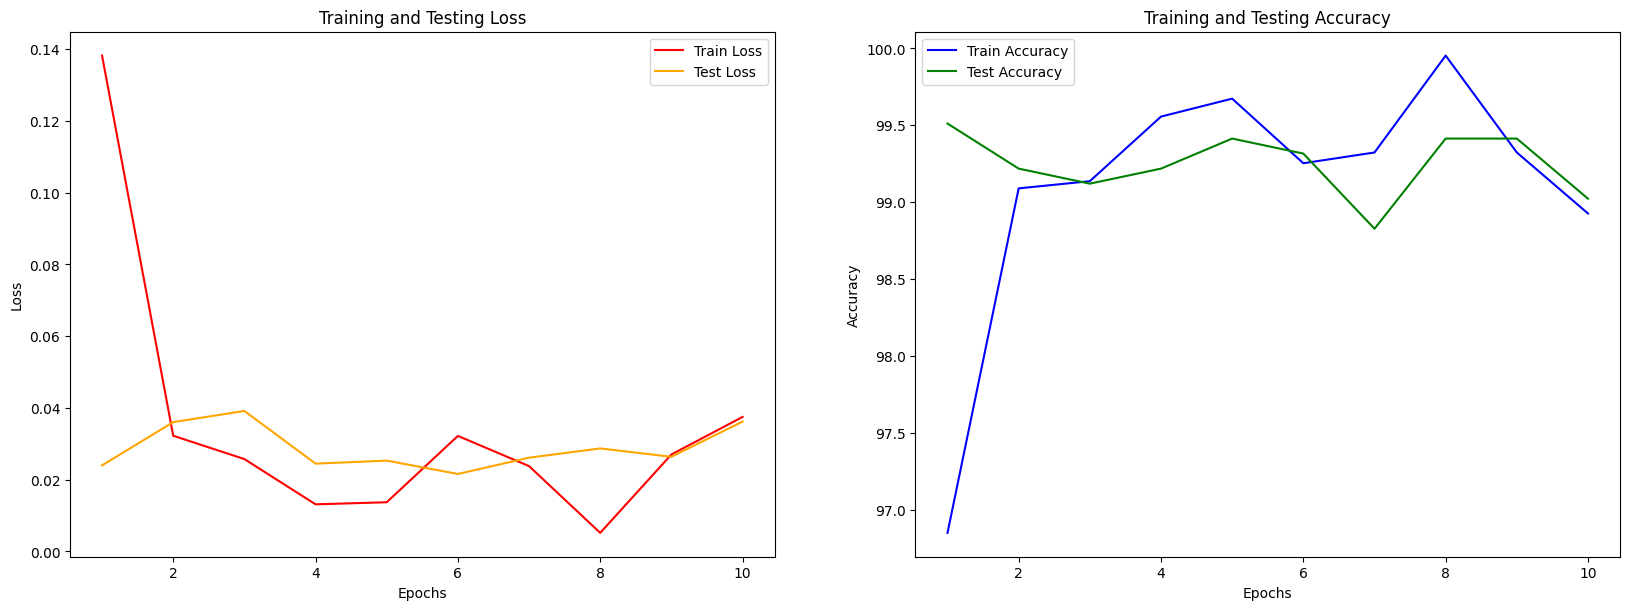

In [66]:
plt.figure(figsize=(20, 15))

nrows, ncols = 2, 2

plt.subplot(nrows, ncols, 1)
plt.plot(epochs_list, train_loss_list, color='red', label='Train Loss')
plt.plot(epochs_list, test_loss_list, color='orange', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(nrows, ncols, 2)
plt.plot(epochs_list, train_acc_list, color='blue', label='Train Accuracy')
plt.plot(epochs_list, test_acc_list, color='green', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.savefig('training_testing_plot.png', dpi=300, bbox_inches='tight')
plt.legend()

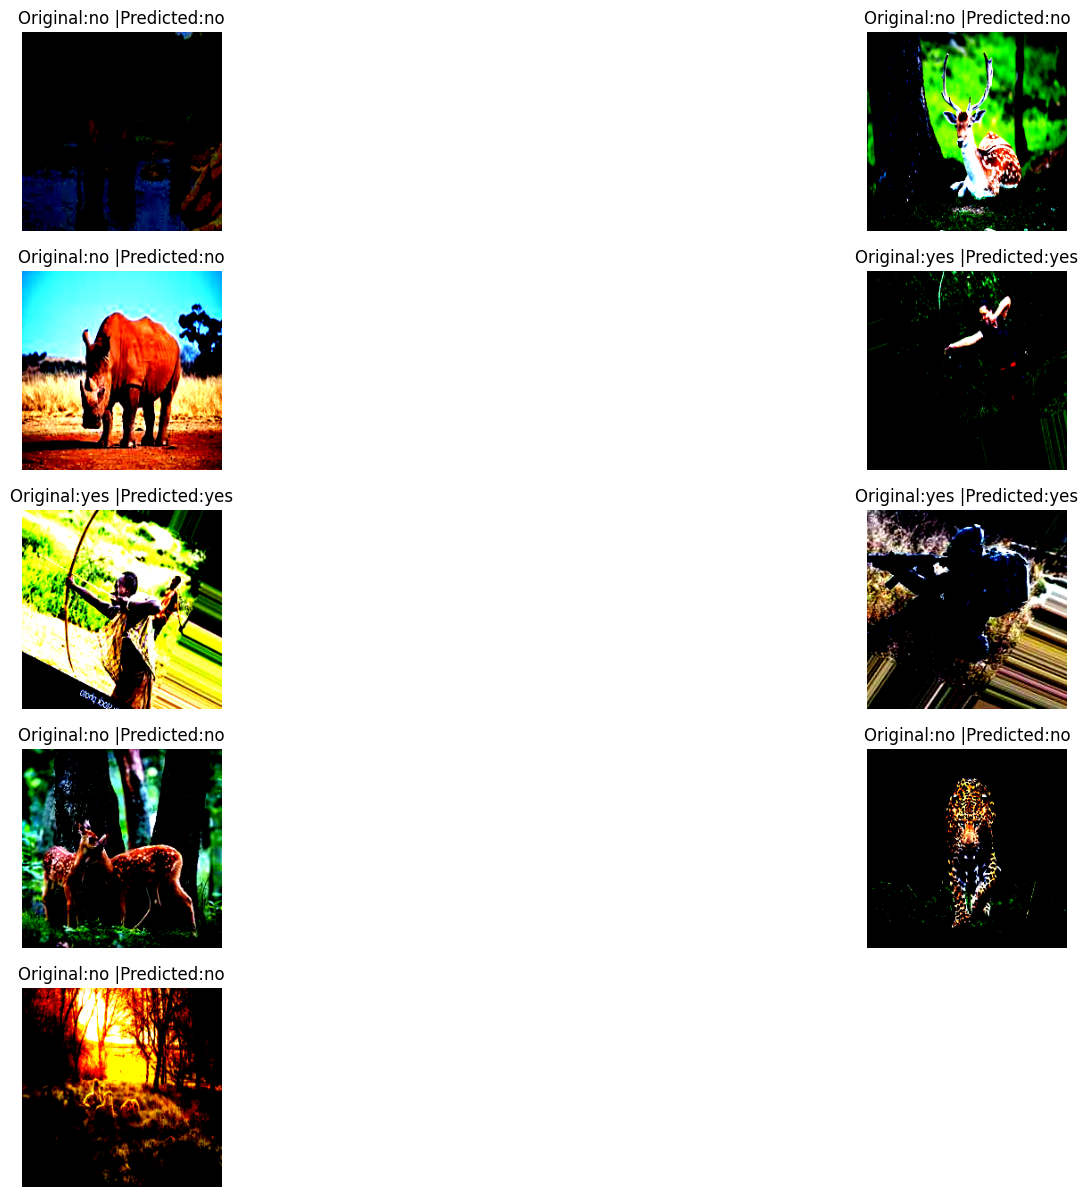

In [64]:
i=1
plt.figure(figsize=(20,15))
nrows,ncols=5,2
model.eval()
with torch.inference_mode():
    for i in range(1,10):
        idx=np.random.randint(0,len(test_dataset))
        img,label=test_dataset[idx]
        img=img.to(device)
        y_pred=model(img.unsqueeze(dim=0))
        y_label=torch.round(torch.sigmoid(y_pred)).int()
        plt.subplot(nrows,ncols,i)
        plt.imshow(img.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'Original:{class_list[label]} |Predicted:{class_list[y_label]}')
        plt.axis('off')
        i+=1
    
    
#plt.savefig('results-4.png')

In [65]:
# Save the state dict of the model
torch.save(model.state_dict(), 'garuda_drishtiV1.pth')
